In [1]:
from dotenv import load_dotenv
import json
import os
from langchain.prompts import SystemMessagePromptTemplate
from langchain_core.messages import AIMessage, SystemMessage, BaseMessage
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Annotated, NotRequired, TypedDict


MODEL = "mistral-nemo"
TEMPERATURE = 0
load_dotenv('.env', override=True)


class State(TypedDict):
    messages: Annotated[list[str], add_messages]
    # messages: list[BaseMessage]
    claim: str
    evidence: list[str]
    label: str | None
    justification: str | None


LLM_OUTPUT_FORMAT = {
    "type": "object",
    "properties": {
        "label": {
            "type": "string",
            "enum": ["true", "false", "unknown"]
        },
        "justification": {
            "type": "string"
        }
    },
    "required": ["label", "justification"]
}

llm = ChatOllama(
    model=MODEL, 
    temperature=TEMPERATURE,
    format=LLM_OUTPUT_FORMAT,
    # base_url="http://host.docker.internal:11434", # if running in the studio
    )



"""
4. Define Nodes: functions taking state and returning state
"""
with open("prompts/reasoning_agent_system_prompt.txt", "r") as f:
    system_prompt = f.read()

def preprocessing(state: State) -> State:
    """
    Formats the system prompt template with the evidence, then supplies the claim
    as a human message. The working assumption is that putting the evidence in the
    system prompt will help make the model trust it more than the claim.
    """
    # Format system prmopt template: unwind the evidence list to a bullet list
    evidence_str = "\n".join([f"* {e}" for e in state["evidence"]])
    formatted_prompt = system_prompt.format(evidence=evidence_str)

    # Set system and human messages in the state
    state['messages'] = [SystemMessage(content=formatted_prompt)]
    return {'messages': HumanMessage(content=state['claim'])}

# TODO: add format instructions
def assistant(state: State) -> State:
    response = llm.invoke(state['messages'])
    return {"messages": response}

def postprocessing(state: State) -> State:
    """
    #TODO: migrate the postprocessing logic to Pydantic/Langchain
    """
    reasoning = state['messages'][-1].content

    try:
        # Try to parse the reasoning as JSON
        formatted_reasoning = json.loads(reasoning)
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError: {e}")
        print(f"Reasoning content: {reasoning}")

    label = formatted_reasoning['label']
    justification = formatted_reasoning['justification']
    
    # prompt = """Format the response into a JSON object with the following keys:
    #     "label": "true" | "false" | "unknown"
    #     "justification": "Justification for the label (string)"
    # """
    # # formatted_reasoning = llm.invoke(reasoning + '\n' + prompt)
    # results = json.loads(formatted_reasoning.content)
    # label = results['label']
    # justification = results['justification']
    return {"label": label, "justification": justification}





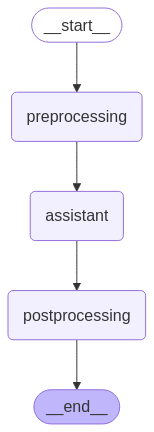

In [2]:
from IPython.display import Image, display
"""
5. Build the graph
"""

builder = StateGraph(State)
builder.add_node("preprocessing", preprocessing)
builder.add_node("assistant", assistant)
builder.add_node("postprocessing", postprocessing)

builder.add_edge(START, "preprocessing")
builder.add_edge("preprocessing", "assistant")

builder.add_edge("assistant", "postprocessing")
builder.add_edge("postprocessing", END)
graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [3]:
from langchain_core.messages import HumanMessage
claim = "George Washington was the first president of the United States."
evidence = ["George Washington was born in 1732.", "George Washington was a general in the Revolutionary War.", "George Washington was elected president in 1789."]
initial_state = {"claim": claim, "evidence": evidence}
final_state = graph.invoke(initial_state)

In [4]:
print(f"Label: {final_state['label']}")
print(f"Justification: {final_state['justification']}")
print("Messages:")
for m in final_state['messages']:
    m.pretty_print()

Label: true
Justification: George Washington served as the first President of the United States, serving two terms from April 30, 1789, until his death on December 14, 1799.
Messages:
================================ Human Message =================================

George Washington was the first president of the United States.
================================== Ai Message ==================================

{ "label": "true" , "justification": "George Washington served as the first President of the United States, serving two terms from April 30, 1789, until his death on December 14, 1799." }
